In [2]:
import numpy as np

inceptionv3_model = np.load("InceptionV3_history_fine.npy", allow_pickle=True).item() #Import

efficientNet_model = np.load("EfficientNetHistory.npy", allow_pickle=True).item() #Import
mobilenetv2_model = np.load("MobileNetV2_history_fine.npy", allow_pickle=True).item() #Import




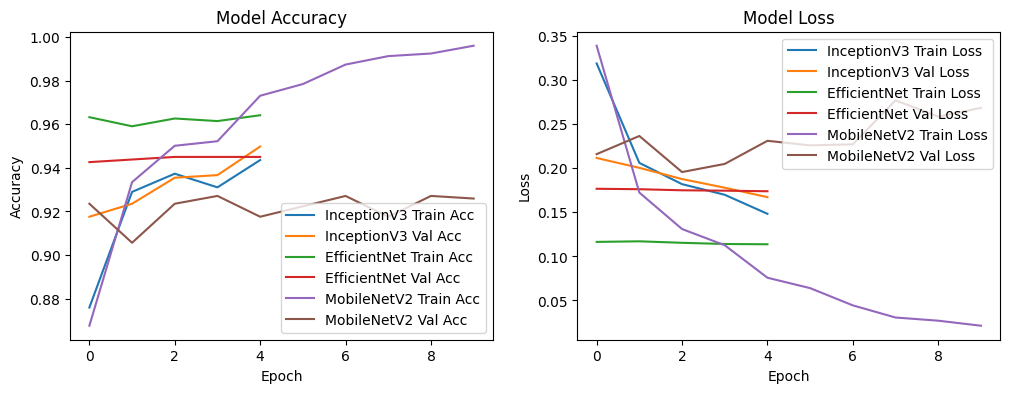

In [3]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values as well as loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(inceptionv3_model['accuracy'], label='InceptionV3 Train Acc')
plt.plot(inceptionv3_model['val_accuracy'], label='InceptionV3 Val Acc')
plt.plot(efficientNet_model['accuracy'], label='EfficientNet Train Acc')    
plt.plot(efficientNet_model['val_accuracy'], label='EfficientNet Val Acc')
plt.plot(mobilenetv2_model['accuracy'], label='MobileNetV2 Train Acc')
plt.plot(mobilenetv2_model['val_accuracy'], label='MobileNetV2 Val Acc')
plt.title('Model Accuracy') 
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(inceptionv3_model['loss'], label='InceptionV3 Train Loss')
plt.plot(inceptionv3_model['val_loss'], label='InceptionV3 Val Loss')
plt.plot(efficientNet_model['loss'], label='EfficientNet Train Loss')
plt.plot(efficientNet_model['val_loss'], label='EfficientNet Val Loss')
plt.plot(mobilenetv2_model['loss'], label='MobileNetV2 Train Loss')
plt.plot(mobilenetv2_model['val_loss'], label='MobileNetV2 Val Loss')
plt.title('Model Loss') 
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

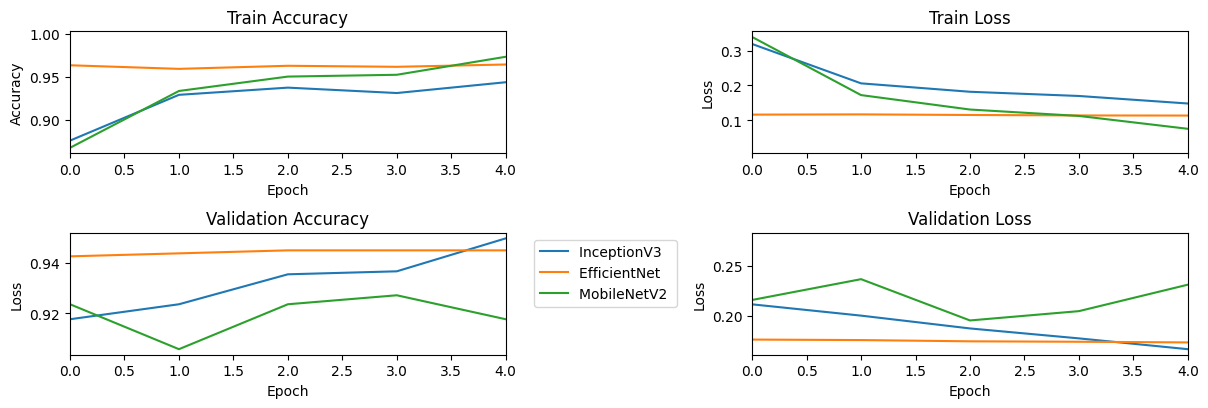

In [30]:

import matplotlib.pyplot as plt
# Plot training & validation accuracy values as well as loss values
plt.figure(figsize=(12, 4))
plt.subplot(2, 2, 1) # This activates the first subplot (top-left)
plt.plot(inceptionv3_model['accuracy'], label='InceptionV3 Train Acc')
plt.plot(efficientNet_model['accuracy'], label='EfficientNet Train Acc')    
plt.plot(mobilenetv2_model['accuracy'], label='MobileNetV2 Train Acc')
plt.title('Train Accuracy') 
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim([0, 4])   

plt.subplot(2, 2, 2) # This activates the second subplot (top-right)
plt.plot(inceptionv3_model['loss'], label='InceptionV3 Train Loss')
plt.plot(efficientNet_model['loss'], label='EfficientNet Train Loss')
plt.plot(mobilenetv2_model['loss'], label='MobileNetV2 Train Loss')
plt.title('Train Loss') 
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim([0, 4])   

plt.subplot(2, 2, 4) # This activates the third subplot (bottom-left)
plt.plot(inceptionv3_model['val_loss'], label='InceptionV3 Val Loss')
plt.plot(efficientNet_model['val_loss'], label='EfficientNet Val Loss')
plt.plot(mobilenetv2_model['val_loss'], label='MobileNetV2 Val Loss')

plt.title('Validation Loss') 
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim([0, 4])   

plt.subplot(2, 2, 3) # This activates the fourth subplot (bottom-right)
plt.plot(inceptionv3_model['val_accuracy'], label='InceptionV3 ')
plt.plot(efficientNet_model['val_accuracy'], label='EfficientNet ')
plt.plot(mobilenetv2_model['val_accuracy'], label='MobileNetV2 ')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))


plt.title('Validation Accuracy') 
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim([0, 4])   
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


plt.show()
